In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import datetime
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr

sns.set_style("darkgrid")
register_matplotlib_converters()
%matplotlib inline

## Import data

In [2]:
data_path = '../data/cmm_erdos_bootcamp_2020_timeseries.pq'

cmm = pq.read_table(source=data_path).to_pandas()

##  Functions used to perform cross-correlation

In [3]:
def rotate_left(arr, antilag):
    antilag = antilag % len(arr)
    return np.concatenate([arr[antilag:], arr[:antilag]])

def rotate_right(arr, lag):
    lag = lag % len(arr)
    return np.concatenate([arr[-lag:], arr[:-lag]])

def crosscorr(data_x, data_y, min_data_y_lag = -10, max_data_y_lag = 10):
    lag_vals = list(range(min_data_y_lag, max_data_y_lag+1))
    crosscorr = [pearsonr(data_x, rotate_right(data_y, lag))[0] for lag in lag_vals]
    return crosscorr

## "Animated" cross-correlation plots between customer A vs. B

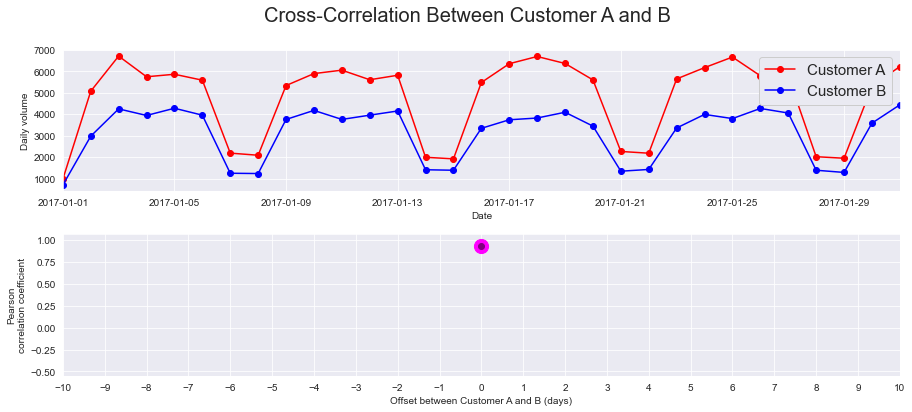

In [ ]:
min_customer2_lag = -10
max_customer2_lag = 10

def plot_shifted_timeseries_and_crosscor_plot(customer1_string, customer2_string, min_customer2_lag = -10, max_customer2_lag = 10):

    date_start = datetime.date(2017, 1, 1)  # cmm.date_val.values[0]
    date_end = datetime.date(2017, 1, 31)  # cmm.date_val.values[-1]

    dA = cmm[['volume_A']].values.flatten()
    dB = cmm[['volume_B']].values.flatten()
    dC = cmm[['volume_C']].values.flatten()
    
    if customer1_string == 'A':
        data1 = dA
        customer1_color = 'red'
    elif customer1_string == 'B':
        data1 = dB
        customer1_color = 'blue'
    else:
        data1 = dC
        customer1_color = 'green'
    
    if customer2_string == 'A':
        data2 = dA
        customer2_color = 'red'
    elif customer2_string == 'B':
        data2 = dB
        customer2_color = 'blue'
    else:
        data2 = dC
        customer2_color = 'green'

    if customer1_string == 'A' and customer2_string == 'B':
        crosscorr12_color = 'purple'
    else:
        crosscorr12_color = 'lightseagreen'

    highlight_color = 'magenta'

    lag_vals = list(range(min_customer2_lag, max_customer2_lag+1))

    # FIRST BATCH OF PLOTS (FROM LAG=0 TO 10)
    for customer2_lag in range(0, max_customer2_lag+1):

        lag_vals_to_probe = list(range(0, customer2_lag+1))

        crosscorr12 = crosscorr(data1, data2, 0, customer2_lag)

        fig,ax=plt.subplots(nrows=2, ncols=1, figsize=(15,6))

        fig.suptitle('Cross-Correlation Between Customer ' + customer1_string + ' and ' + customer2_string, fontsize=20)

        fig.subplots_adjust(
            hspace = 0.3)

        ax[0].plot(cmm.date_val, cmm['volume_'+customer1_string], marker='o', color=customer1_color, label='Customer '+customer1_string)
        ax[0].plot(cmm.date_val, rotate_right(cmm['volume_'+customer2_string],customer2_lag), marker='o', color=customer2_color, label='Customer '+customer2_string)

        ymin_plot1 = np.min(np.min(cmm[['volume_'+customer1_string,'volume_'+customer2_string]][(cmm.date_val >= date_start) & (cmm.date_val <= date_end)]))
        ymax_plot1 = np.max(np.max(cmm[['volume_'+customer1_string,'volume_'+customer2_string]][(cmm.date_val >= date_start) & (cmm.date_val <= date_end)]))
        Delta_y_plot1 = ymax_plot1 - ymin_plot1
    
        ax[0].set(
            xlim=[date_start, date_end],
            ylim=[ymin_plot1 - 0.05*Delta_y_plot1,ymax_plot1 + 0.05*Delta_y_plot1],
            xlabel='Date',
            ylabel='Daily volume',
        )
        ax[0].legend(fontsize=15,
                     loc='upper right',
                     framealpha=1)

        ax[1].plot(lag_vals_to_probe, crosscorr12, marker='o', color=crosscorr12_color)
        ax[1].scatter(lag_vals_to_probe[-1], crosscorr12[-1], marker='o', s=200, color=highlight_color)
        ax[1].set(
            xlim=[min(lag_vals),max(lag_vals)],
            ylim=[-0.55,1.07],
            xlabel='Offset between Customer ' + customer1_string + ' and ' + customer2_string + ' (days)',
            ylabel='Pearson\ncorrelation coefficient',
            xticks=lag_vals,
        )

        fig.savefig('../figs/crosscorrelations/animation/crosscorr_' + customer1_string + customer2_string + '_batch_1_lag=' + str(customer2_lag) + '.png', dpi=400)

        plt.show()
        
        plt.close()

    # SECOND BATCH OF PLOTS (FROM LAG=0 TO -10)
    for customer2_lag in range(-10, 0+1):

        lag_vals_to_probe = list(range(customer2_lag, 10+1))

        crosscorr12 = crosscorr(data1, data2, customer2_lag, 10)

        fig,ax=plt.subplots(nrows=2, ncols=1, figsize=(15,6))

        fig.suptitle('Cross-Correlation Between Customer ' + customer1_string + ' and ' + customer2_string, fontsize=20)

        fig.subplots_adjust(
            hspace = 0.3)

        ax[0].plot(cmm.date_val, cmm['volume_'+customer1_string], marker='o', color=customer1_color, label='Customer '+customer1_string)
        ax[0].plot(cmm.date_val, rotate_right(cmm['volume_'+customer2_string],customer2_lag), marker='o', color=customer2_color, label='Customer '+customer2_string)

        ymin_plot1 = np.min(np.min(cmm[['volume_'+customer1_string,'volume_'+customer2_string]][(cmm.date_val >= date_start) & (cmm.date_val <= date_end)]))
        ymax_plot1 = np.max(np.max(cmm[['volume_'+customer1_string,'volume_'+customer2_string]][(cmm.date_val >= date_start) & (cmm.date_val <= date_end)]))
        Delta_y_plot1 = ymax_plot1 - ymin_plot1
    
        ax[0].set(
            xlim=[date_start, date_end],
            ylim=[ymin_plot1 - 0.05*Delta_y_plot1,ymax_plot1 + 0.05*Delta_y_plot1],
            xlabel='Date',
            ylabel='Daily volume',
        )
        ax[0].legend(fontsize=15,
                     loc='upper right',
                     framealpha=1)

        ax[1].plot(lag_vals_to_probe, crosscorr12, marker='o', color=crosscorr12_color)
        ax[1].scatter(lag_vals_to_probe[0], crosscorr12[0], marker='o', s=200, color=highlight_color)
        ax[1].set(
            xlim=[min(lag_vals),max(lag_vals)],
            ylim=[-0.55,1.07],
            xlabel='Offset between Customer ' + customer1_string + ' and ' + customer2_string + ' (days)',
            ylabel='Pearson\ncorrelation coefficient',
            xticks=lag_vals,
        )

        fig.savefig('../figs/crosscorrelations/animation/crosscorr_' + customer1_string + customer2_string + '_batch_2_lag=' + str(customer2_lag) + '.png', dpi=400)

        plt.show()
        
        plt.close()

plot_shifted_timeseries_and_crosscor_plot('A','B')

## Cross-correlation plots between customer A vs. B and B vs. C

In [ ]:
dA = cmm[['volume_A']].values.flatten()
dB = cmm[['volume_B']].values.flatten()
dC = cmm[['volume_C']].values.flatten()

min_customer2_lag = -10
max_customer2_lag = 10

lag_vals = list(range(min_customer2_lag,max_customer2_lag+1))

crosscorrAB = crosscorr(dA, dB, min_customer2_lag, max_customer2_lag)
crosscorrBC = crosscorr(dB, dC, min_customer2_lag, max_customer2_lag)

font = {'family' : 'sans-serif'}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset']='cm'
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

fig,ax=plt.subplots(nrows=2, ncols=1, figsize=(15,6))

fig.suptitle('Cross-Correlation', fontsize=20)

fig.subplots_adjust(hspace = 0.3)

ax[0].plot(lag_vals, crosscorrBC, marker='o', color='orange', label='B and C')

ax[0].set(
    xlim=[min(lag_vals),max(lag_vals)],
    ylim=[-0.55,1.07],
    xticks=lag_vals,
)
ax[0].xaxis.set_ticklabels([])
ax[0].legend(fontsize=15,bbox_to_anchor=(0.7, 0.94))

ax[1].plot(lag_vals, crosscorrAB, marker='o', color='purple', label='A and B')

ax[1].set(
    xlim=[min(lag_vals),max(lag_vals)],
    ylim=[-0.55,1.07],
    xlabel='Offset between the two customers',
    xticks=lag_vals,
)
ax[1].legend(fontsize=15,bbox_to_anchor=(0.7, 0.94))

fig.text(0.04, 0.5, 'Pearson correlation coefficient', va='center',rotation='vertical',fontsize=18)

fig.savefig('../figs/crosscorrelations/crosscorr-BC_and_AB.png', dpi=400)

plt.show()
